# Import aller nötigen Module

In [46]:
import os
import joblib
import numpy as np
import pandas as pd
#Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
# Filtering
from scipy.signal import butter, filtfilt
from scipy import stats

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import plot_tree

# Hilfsfunktionen
Hier definieren wir unsere Hilfsfunktionen zum Plotten

In [47]:
# Vordefinierte Hilfsfunktion zum plotten
def plot_filter(dataframe, data_column_name, filtered_column_name, title):
    fig = px.line(dataframe, x='Time (s)', y=[data_column_name, filtered_column_name], title=title)
    fig.update_xaxes(title_text='Time')
    fig.update_yaxes(title_text=filtered_column_name)
    fig.show() 

# Datenimport

Hier laden wir unsere .pyphox Dateien und fangen ab, falls diese nicht vorhanden sein solte. Zudem setzen wir schoonmal die Spaltennamen fest um diese im fortlaufenen Programm nutzen zu können

In [48]:
# Error-Handling
try:
    dataframeHammer = pd.read_csv("RawDataHammer.csv")
    dataframeWischen = pd.read_csv("RawDataWisch.csv")
except FileNotFoundError:
    print(f"Error: File not found")
    exit()

# Vorschau der Daten
print("Dataset Hammer:")
print(dataframeHammer.head())
print("Dataset Wischen:")
print(dataframeWischen.head())


Dataset Hammer:
   Time (s)  Linear Acceleration x (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.095744                          0.001                          0.060   
1  0.100726                          0.001                          0.031   
2  0.105707                          0.000                         -0.001   
3  0.110688                         -0.003                         -0.053   
4  0.115670                         -0.005                         -0.078   

   Linear Acceleration z (m/s^2)  Absolute acceleration (m/s^2)  
0                         -0.015                       0.061855  
1                         -0.007                       0.031796  
2                          0.000                       0.001000  
3                          0.014                       0.054900  
4                          0.020                       0.080678  
Dataset Wischen:
   Time (s)  Linear Acceleration x (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.093435                    

# Frequenzfilter

Hier wird das Rauschen reduziert. Dafür nutzen wir Butterworth aus der Vorlesung. Damit werden hoch- bzw. niederfrequente Signale gefiltert. 
Zuerst folgen die niederfrequenten Signale, dann die hochfrequenten:

In [49]:
filtered_dataframeHammer = dataframeHammer.copy()
filtered_dataframeWischen = dataframeWischen.copy()

filter_order = 4  

low_cutoff = 0.5
high_cutoff = 5 

# Hier nutzen wir den butterwort filter um die Daten zu glätten
b, a = butter(filter_order, [low_cutoff, high_cutoff], btype='band', analog=False, fs =100)

# Wende den Filter auf die Beschleunigungssignale an
filtered_dataframeWischen['filtered_X_band'] = filtfilt(b, a, dataframeWischen['Linear Acceleration x (m/s^2)'])
filtered_dataframeWischen['filtered_Y_band'] = filtfilt(b, a, dataframeWischen['Linear Acceleration y (m/s^2)'])
filtered_dataframeWischen['filtered_Z_band'] = filtfilt(b, a, dataframeWischen['Linear Acceleration z (m/s^2)'])

plot_filter(filtered_dataframeWischen, 'Linear Acceleration x (m/s^2)', 'filtered_X_band', 'Acceleration X (Wischen) with Band-Pass Filtering')
plot_filter(filtered_dataframeWischen, 'Linear Acceleration y (m/s^2)', 'filtered_Y_band', 'Acceleration Y (Wischen) with Band-Pass Filtering')
plot_filter(filtered_dataframeWischen, 'Linear Acceleration z (m/s^2)', 'filtered_Z_band', 'Acceleration Z (Wischen) with Band-Pass Filtering')

filtered_dataframeHammer['filtered_X_band'] = filtfilt(b, a, dataframeHammer['Linear Acceleration x (m/s^2)'])
filtered_dataframeHammer['filtered_Y_band'] = filtfilt(b, a, dataframeHammer['Linear Acceleration y (m/s^2)'])
filtered_dataframeHammer['filtered_Z_band'] = filtfilt(b, a, dataframeHammer['Linear Acceleration z (m/s^2)'])

plot_filter(filtered_dataframeHammer, 'Linear Acceleration x (m/s^2)', 'filtered_X_band', 'Acceleration X (Hammer) with Band-Pass Filtering')
plot_filter(filtered_dataframeHammer, 'Linear Acceleration y (m/s^2)', 'filtered_Y_band', 'Acceleration Y (Hammer) with Band-Pass Filtering')
plot_filter(filtered_dataframeHammer, 'Linear Acceleration z (m/s^2)', 'filtered_Z_band', 'Acceleration Z (Hammer) with Band-Pass Filtering')

# Ausreißer Bereinigung
Hier wollen wir nun die möglichen Ausreißer bereinigen: 

In [50]:
# Berechnung der Z-Scores für jede Spalte (X, Y, Z)
filtered_dataframeWischen['Z_Score_X_band'] = stats.zscore(filtered_dataframeWischen['filtered_X_band'])
filtered_dataframeWischen['Z_Score_Y_band'] = stats.zscore(filtered_dataframeWischen['filtered_Y_band'])
filtered_dataframeWischen['Z_Score_Z_band'] = stats.zscore(filtered_dataframeWischen['filtered_Z_band'])

filtered_dataframeHammer['Z_Score_X_band'] = stats.zscore(filtered_dataframeHammer['filtered_X_band'])
filtered_dataframeHammer['Z_Score_Y_band'] = stats.zscore(filtered_dataframeHammer['filtered_Y_band'])
filtered_dataframeHammer['Z_Score_Z_band'] = stats.zscore(filtered_dataframeHammer['filtered_Z_band'])

# Festlegen eines Schwellenwerts für Z-Scores, ab dem ein Punkt als Ausreißer betrachtet wird
z_score_threshold = 4  

# Filtern der Ausreißer aus dem filterd_dataframe (nur wenn alle drei Achsen unterhalb des Threshold liegen sind Daten ok)
filtered_dataframeWischen = filtered_dataframeWischen[(abs(filtered_dataframeWischen['Z_Score_X_band']) <= z_score_threshold) &
                     (abs(filtered_dataframeWischen['Z_Score_Y_band']) <= z_score_threshold) &
                     (abs(filtered_dataframeWischen['Z_Score_Z_band']) <= z_score_threshold)]

filtered_dataframeHammer = filtered_dataframeHammer[(abs(filtered_dataframeHammer['Z_Score_X_band']) <= z_score_threshold) &
                     (abs(filtered_dataframeHammer['Z_Score_Y_band']) <= z_score_threshold) &
                     (abs(filtered_dataframeHammer['Z_Score_Z_band']) <= z_score_threshold)]

# Jetzt enthält 'filtered_dataframe' nur noch die Datenpunkte, die nicht als Ausreißer betrachtet werden.
print(filtered_dataframeWischen.shape)
print(filtered_dataframeHammer.shape)

#Plotting
plot_filter(filtered_dataframeWischen, 'Linear Acceleration x (m/s^2)', 'Z_Score_X_band', 'Acceleration (Wischen) X with Z-Score Filtering')
plot_filter(filtered_dataframeWischen, 'Linear Acceleration y (m/s^2)', 'Z_Score_Y_band', 'Acceleration (Wischen) Y with Z-Score Filtering')
plot_filter(filtered_dataframeWischen, 'Linear Acceleration z (m/s^2)', 'Z_Score_Z_band', 'Acceleration (Wischen) Z with Z-Score Filtering')

plot_filter(filtered_dataframeHammer, 'Linear Acceleration x (m/s^2)', 'Z_Score_X_band', 'Acceleration (Hammer) X with Z-Score Filtering')
plot_filter(filtered_dataframeHammer, 'Linear Acceleration y (m/s^2)', 'Z_Score_Y_band', 'Acceleration (Hammer) Y with Z-Score Filtering')
plot_filter(filtered_dataframeHammer, 'Linear Acceleration z (m/s^2)', 'Z_Score_Z_band', 'Acceleration (Hammer) Z with Z-Score Filtering')


(3966, 11)
(3997, 11)


# Windowing
Hier nutzen wir Windowing um die Daten zu zerlegen. Das brauchen wir später für die Features-Berechnung

In [51]:
# Da fs = 100 Hz setzen wir das Fenster auf 0.5 Sekunden um auch kurze Bewegungsereignisse abzubilden. 
# Wir könnten window_size aber auch auf 200 setzen.
window_size = 150
overlap = 25

#Für jedes Fenster in den Daten neuen Dataframe erstellen, der in Liste abgelegt wird 
def create_windows(df):
    windows = []
    for i in range(0, len(df), window_size - overlap):
        window = df.iloc[i:i+window_size]
        if len(window) == window_size:
            windows.append(window)
    return windows

windows_wischen = create_windows(filtered_dataframeWischen)
windows_hammer = create_windows(filtered_dataframeHammer)



#Ersten Dataframe in der Liste ausgeben lassen 
print("Wischen: ")
print(windows_wischen[0].head())
print("Hammer: ")
print(windows_hammer[0].head())
#Anzahl Datenpunkte des ersten Dataframes ausgeben lassen 
print("Wischen: ")
print(len(windows_wischen[0]))
print("Hammer: ")
print(len(windows_hammer[0]))
#Spalten des ersten Dataframes ausgeben lassen 
print("Wischen: ")
print(windows_wischen[0].columns)
print("Hammer: ")
print(windows_hammer[0].columns)

#Ausgeben lassen wie viele Dataframes also Fenster entstanden sind 
print("Wischen: ")
print (len(windows_wischen))
print("Hammer: ")
print (len(windows_hammer))


Wischen: 
   Time (s)  Linear Acceleration x (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.093435                          0.003                          0.139   
1  0.098417                          0.003                          0.143   
2  0.103398                          0.003                          0.129   
3  0.108380                          0.003                          0.115   
4  0.113361                          0.003                          0.098   

   Linear Acceleration z (m/s^2)  Absolute acceleration (m/s^2)  \
0                         -0.007                       0.139208   
1                         -0.008                       0.143255   
2                         -0.007                       0.129225   
3                         -0.006                       0.115195   
4                         -0.006                       0.098229   

   filtered_X_band  filtered_Y_band  filtered_Z_band  Z_Score_X_band  \
0         1.766853        -0.680250         0.225847

# Features erstellen
Hier berechnen wir die Merkmale, die wesentliche Eigneschaften der Daten kompakt beschreiben. Diese dienen als Eingabe für den späteren Entscheidungsbaum. 

In [52]:
# Funktion zur Feature-Extraktion aus Fenster-Daten
def extract_features(windows, label_name):
    # Leere Liste für die Feature-Dictionaries
    feature_list = []
    # Schleife über alle Fenster
    for window in windows:
        # Berechnung der Features für X, Y, Z Achsen
        features = {
            'BeschleunigungX_Mittelwert': window['filtered_X_band'].mean(),
            'BeschleunigungY_Mittelwert': window['filtered_Y_band'].mean(),
            'BeschleunigungZ_Mittelwert': window['filtered_Z_band'].mean(),
            'BeschleunigungX_Std': window['filtered_X_band'].std(),
            'BeschleunigungY_Std': window['filtered_Y_band'].std(),
            'BeschleunigungZ_Std': window['filtered_Z_band'].std(),
            'BeschleunigungX_Max': window['filtered_X_band'].max(),
            'BeschleunigungY_Max': window['filtered_Y_band'].max(),
            'BeschleunigungZ_Max': window['filtered_Z_band'].max(),
            'BeschleunigungX_Min': window['filtered_X_band'].min(),
            'BeschleunigungY_Min': window['filtered_Y_band'].min(),
            'BeschleunigungZ_Min': window['filtered_Z_band'].min(),
            'label': label_name
        }
        # Features des Fensters der Liste hinzufügen
        feature_list.append(features)
    # Alle Features in einen DataFrame umwandeln und zurückgeben
    return pd.DataFrame(feature_list)

# Feature-DataFrames für Wischen und Hammer erstellen
feature_df_wischen = extract_features(windows_wischen, 'Wischen')
feature_df_hammer = extract_features(windows_hammer, 'Hammer')


# Features zusammenführen

Wir haben momentan 2 verschiedene Feature-Listen. Diese wollen wir zusammenführen. Der Baum kann anhand der Label (0 für Wischen und 1 für Hammer) die Features der jeweiligen Datei erkennen. 

In [53]:
feature_df = pd.concat([feature_df_wischen, feature_df_hammer], ignore_index=True)
feature_df = feature_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(feature_df.columns)

Index(['BeschleunigungX_Mittelwert', 'BeschleunigungY_Mittelwert',
       'BeschleunigungZ_Mittelwert', 'BeschleunigungX_Std',
       'BeschleunigungY_Std', 'BeschleunigungZ_Std', 'BeschleunigungX_Max',
       'BeschleunigungY_Max', 'BeschleunigungZ_Max', 'BeschleunigungX_Min',
       'BeschleunigungY_Min', 'BeschleunigungZ_Min', 'label'],
      dtype='object')


# Entscheidungsbaum

Hier trainieren wir den Entscheidungsbaum mit den Daten, die wir vorbereitet haben.

In [54]:
# Features und Zielvariable trennen
X = feature_df.drop(columns=['label'])
y = feature_df['label']

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#Entscheidungsbaum(CART)
clf = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

#Training
clf.fit(X_train, y_train)

#Validierung
y_pred = clf.predict(X_test)

print("Accuracy:\n", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy:
 0.8461538461538461
Confusion Matrix:
 [[6 1]
 [1 5]]
Classification Report:
               precision    recall  f1-score   support

      Hammer       0.86      0.86      0.86         7
     Wischen       0.83      0.83      0.83         6

    accuracy                           0.85        13
   macro avg       0.85      0.85      0.85        13
weighted avg       0.85      0.85      0.85        13



# Entscheidungsbaum visualisieren

Der Entscheidungsbaum wird nun visualisiert, um besser zu verstehen, wie er zu seinen Entscheidungen kommt.

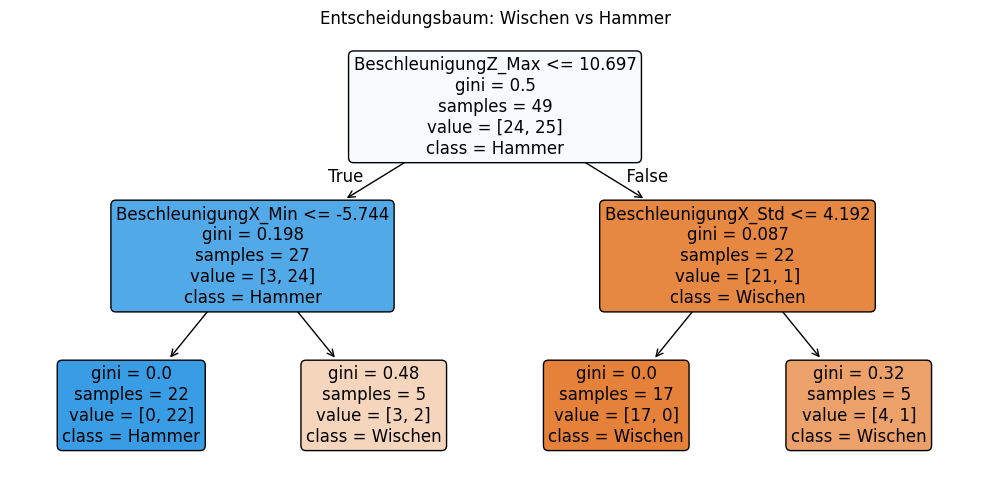

In [55]:
plt.figure(figsize=(10, 5))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=['Wischen', 'Hammer'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Entscheidungsbaum: Wischen vs Hammer")
plt.tight_layout()
plt.show()

# Entscheidungsbaum speichern
Der Entscheidungsbaum wird gespeichert, damit dieser für neue Daten verwendet werden kann.

In [56]:
# Entscheidungsbaum speichern
joblib.dump(clf, "decision_tree_model.pkl")
print("Modell gespeichert")

Modell gespeichert
